In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
df_f_general = pd.read_csv('dwh csv/f_general_metrics.csv')
df_d_dates = pd.read_csv('dwh csv/d_date.csv')
df_f_cases = pd.read_csv('dwh csv/f_cases.csv')
df_risk_scores = pd.read_csv('dwh csv/d_risk_score.csv')
df_ages = pd.read_csv("dwh csv/d_age.csv")
df_inmates = pd.read_csv('dwh csv/d_inmate.csv')

In [32]:
df_f_general.columns

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'date_id',
       'row_id'],
      dtype='object')

In [33]:
df_d_dates['date'] = pd.to_datetime(df_d_dates[['year', 'month', 'day']])


In [34]:
df_general = pd.merge(df_f_general, df_d_dates[['date_id', 'date']], on='date_id', how='left')

In [35]:
df_general.columns

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'date_id',
       'row_id', 'date'],
      dtype='object')

In [36]:
# Mergeing the dataframes based on the screening_date_id
df_cases = pd.merge(df_f_cases, df_d_dates, 
                               how='left', 
                               left_on='screening_date_id', 
                               right_on='date_id', 
                               suffixes=('', '_recidivism_offense'))

In [37]:
df_cases.columns

Index([' Case_id', 'juvenile_felony_count', 'juvenile_misdemeanor_count',
       'juvenile_other_offense_count', 'prior_offense_count',
       'days_between_screening_and_arrest',
       'days_from_compas_to_current_offense', 'is_recidivist', 'arrest_to_rec',
       'is_violent_recidivist', 'charge_id', 'rec_charge_id', 'inmate_id',
       'sentence_type_id', 'state_id', 'recidivism_offense_date_id',
       'current_jail_entry_date_id', 'current_jail_release_date_id',
       'screening_date_id', 'recidivism_risk_score_id',
       'violence_risk_score_id', 'date_id', 'year', 'month', 'day', 'date'],
      dtype='object')

In [38]:
df_general.columns

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'date_id',
       'row_id', 'date'],
      dtype='object')

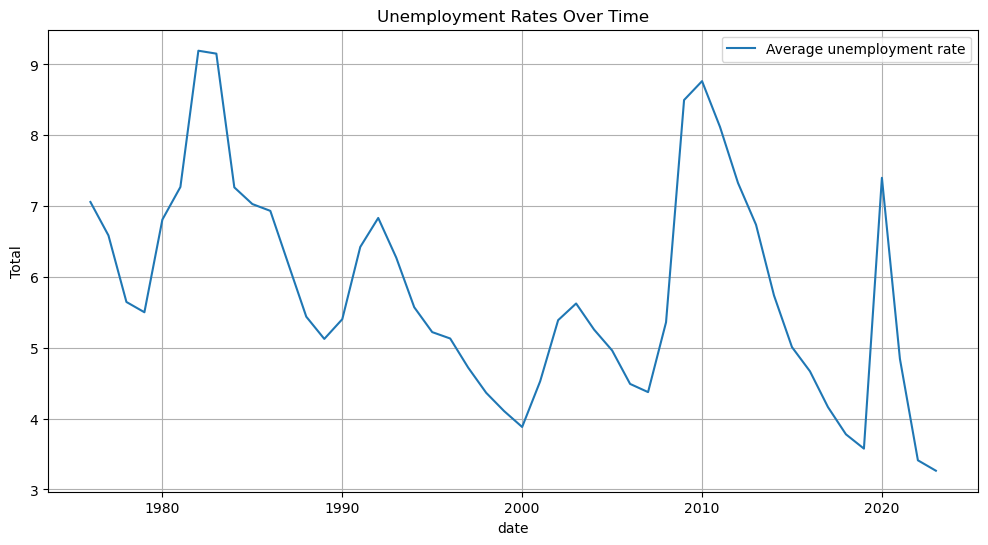

In [39]:
df_general_grouped = df_general.groupby(['date']).agg({
    'violent_crimes_total': 'sum',
    'property_crime_total': 'sum',
    'prisoners_count': 'sum',
    'unemployment_rate': 'mean',
    'poverty_percentage': 'mean',
    'participation_rate' : 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_general_grouped['date'], df_general_grouped['unemployment_rate'], label='Average unemployment rate')
plt.xlabel('date')
plt.ylabel('Total')
plt.title('Unemployment Rates Over Time')
plt.legend()
plt.grid(True)
plt.show()

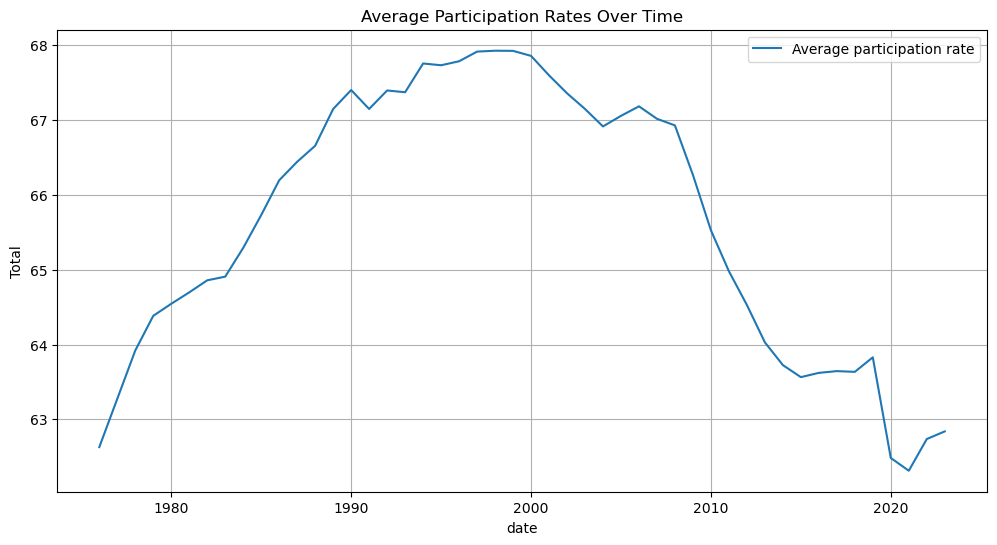

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df_general_grouped['date'], df_general_grouped['participation_rate'], label='Average participation rate')
plt.xlabel('date')
plt.ylabel('Total')
plt.title('Average Participation Rates Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
print(df_general_grouped.columns)

Index(['date', 'violent_crimes_total', 'property_crime_total',
       'prisoners_count', 'unemployment_rate', 'poverty_percentage',
       'participation_rate'],
      dtype='object')


02:29:00 - cmdstanpy - INFO - Chain [1] start processing
02:29:00 - cmdstanpy - INFO - Chain [1] done processing
02:29:01 - cmdstanpy - INFO - Chain [1] start processing
02:29:01 - cmdstanpy - INFO - Chain [1] done processing


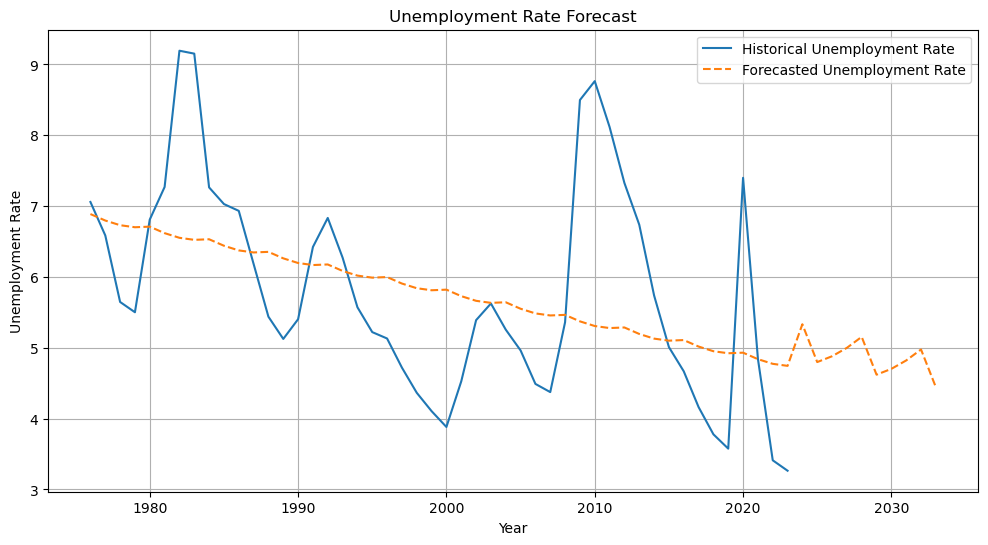

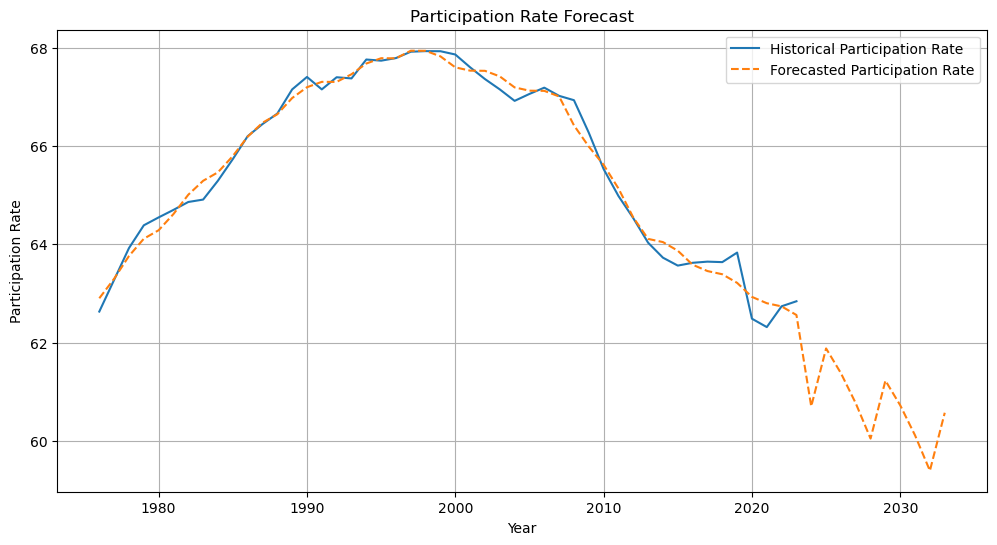

In [42]:
from prophet import Prophet
df_general_grouped['date'] = pd.to_datetime(df_general_grouped['date'], format='%Y')
df_general_grouped.reset_index(drop=True, inplace=True)


df_unemployment = df_general_grouped[['date', 'unemployment_rate']].rename(columns={'date': 'ds', 'unemployment_rate': 'y'})
df_participation = df_general_grouped[['date', 'participation_rate']].rename(columns={'date': 'ds', 'participation_rate': 'y'})

df_unemployment = df_unemployment.dropna()
df_participation = df_participation.dropna()

model_unemployment_prophet = Prophet()
model_unemployment_prophet.fit(df_unemployment)
future_unemployment = model_unemployment_prophet.make_future_dataframe(periods=10, freq='Y')
forecast_unemployment_prophet = model_unemployment_prophet.predict(future_unemployment)

# Fit Prophet model for Participation Rate
model_participation_prophet = Prophet()
model_participation_prophet.fit(df_participation)
future_participation = model_participation_prophet.make_future_dataframe(periods=10, freq='Y')
forecast_participation_prophet = model_participation_prophet.predict(future_participation)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_unemployment['ds'], df_unemployment['y'], label='Historical Unemployment Rate')
plt.plot(forecast_unemployment_prophet['ds'], forecast_unemployment_prophet['yhat'], label='Forecasted Unemployment Rate', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Forecast')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_participation['ds'], df_participation['y'], label='Historical Participation Rate')
plt.plot(forecast_participation_prophet['ds'], forecast_participation_prophet['yhat'], label='Forecasted Participation Rate', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Participation Rate')
plt.title('Participation Rate Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
df_filtered = df_general[(df_general['date'].dt.year >= 2011) & (df_general['date'].dt.year <= 2021)]

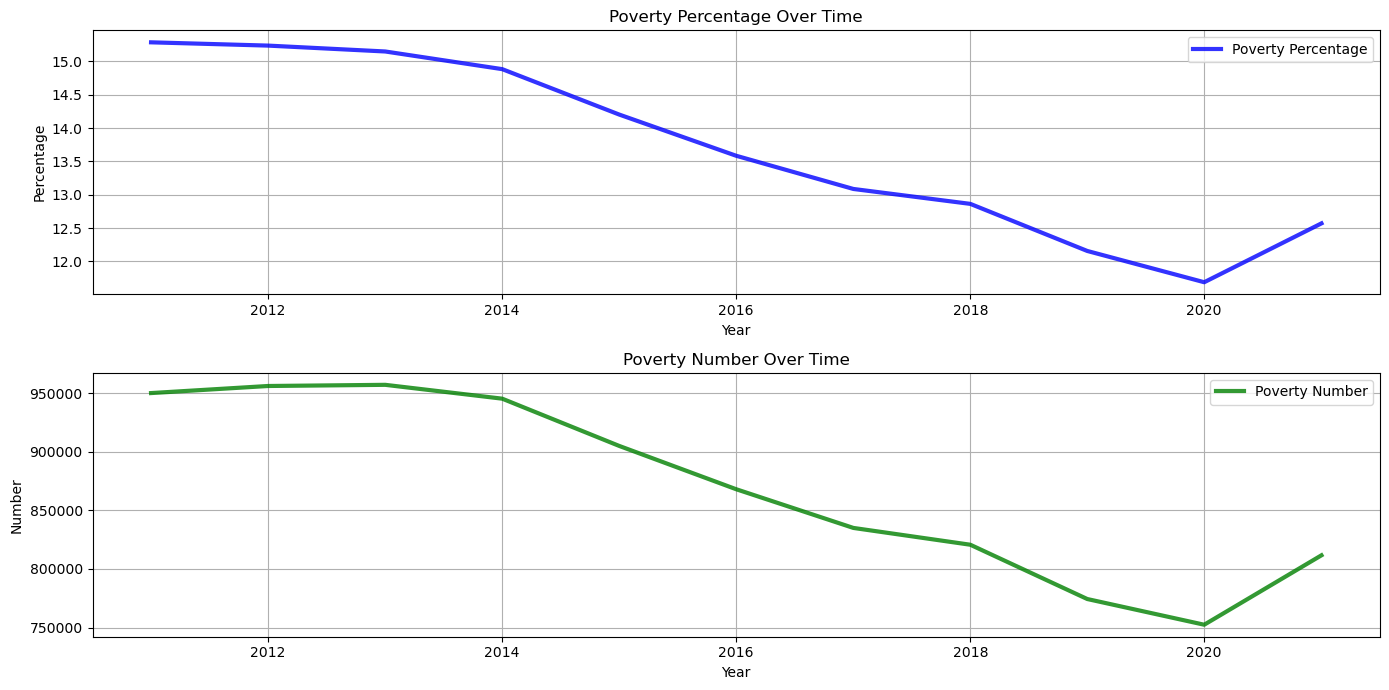

In [44]:

df_yearly = df_filtered.groupby('date').agg({
    'poverty_percentage': 'mean',
    'poverty_nb': 'mean'
}).reset_index()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df_yearly['date'], df_yearly['poverty_percentage'], label='Poverty Percentage', color='blue', alpha=0.8, linewidth=3)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Poverty Percentage Over Time')
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_yearly['date'], df_yearly['poverty_nb'], label='Poverty Number', color='green', alpha=0.8, linewidth=3)
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Poverty Number Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [45]:
df_filtered.loc[:, 'population'] = df_filtered['population'].astype(float)
correlation_percentage = df_filtered[['poverty_percentage', 'population']].corr().iloc[0, 1]
correlation_number = df_filtered[['poverty_nb', 'population']].corr().iloc[0, 1]
print(f'Correlation between Poverty Percentage and Population: {correlation_percentage}')
print(f'Correlation between Poverty Number and Population: {correlation_number}')


Correlation between Poverty Percentage and Population: 0.11380774013899711
Correlation between Poverty Number and Population: 0.9796347420981031


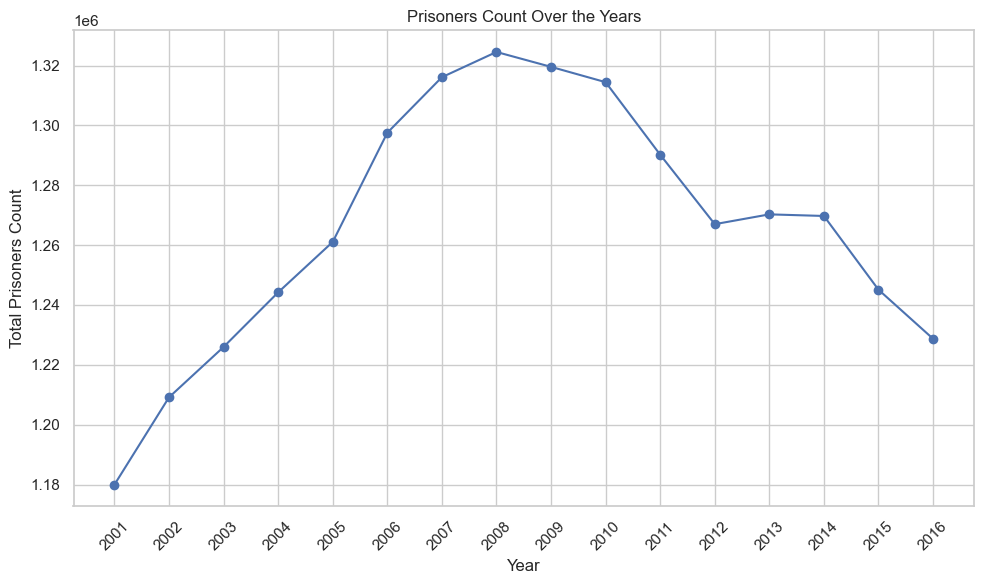

In [180]:
merged_df = pd.merge(df_f_general, df_d_dates, on='date_id')
filtered_df = merged_df[(merged_df['year'] >= 2001) & (merged_df['year'] <= 2016)]
yearly_summary = filtered_df.groupby('year')['prisoners_count'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_summary['year'], yearly_summary['prisoners_count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Prisoners Count')
plt.title('Prisoners Count Over the Years')
plt.grid(True)
plt.xticks(yearly_summary['year'], rotation=45)
plt.tight_layout()
plt.show()

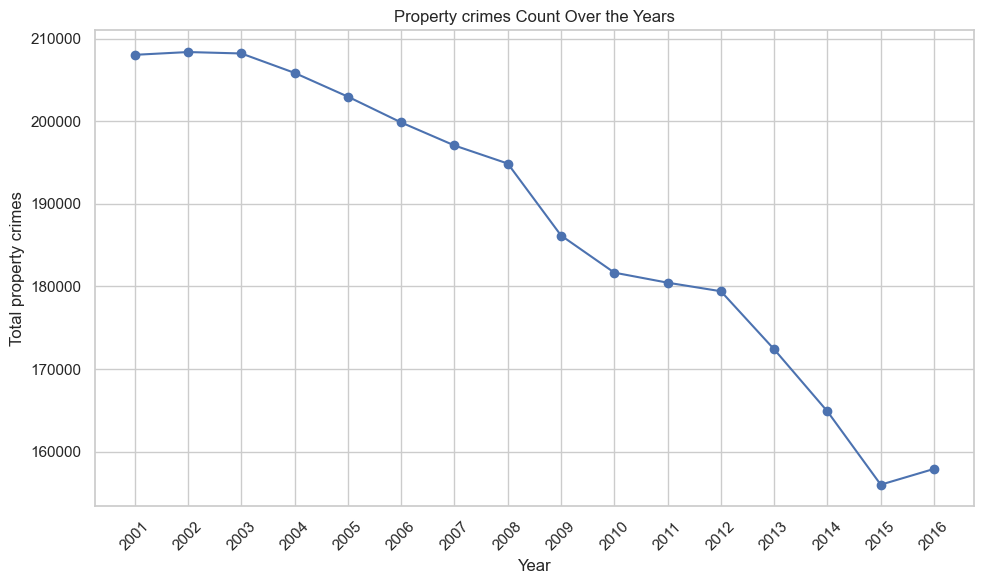

In [186]:
merged_df = pd.merge(df_f_general, df_d_dates, on='date_id')
filtered_df = merged_df[(merged_df['year'] >= 2001) & (merged_df['year'] <= 2016)]
yearly_summary = filtered_df.groupby('year')['property_crime_total'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_summary['year'], yearly_summary['property_crime_total'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total property crimes')
plt.title('Property crimes Count Over the Years')
plt.grid(True)
plt.xticks(yearly_summary['year'], rotation=45)
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4336\1375976246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'poverty_per_capita'] = df_filtered['poverty_nb'] / df_filtered['population']


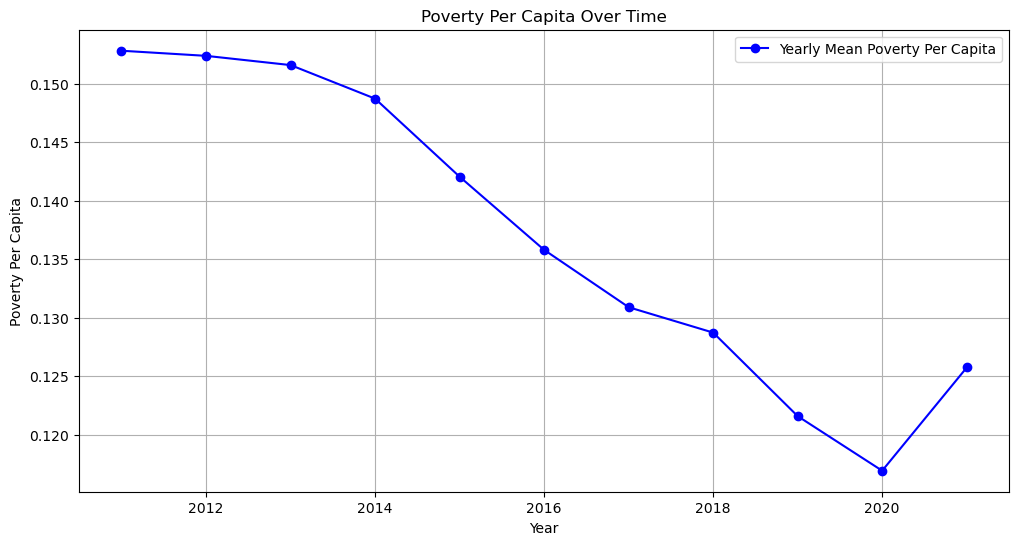

In [46]:

df_filtered.loc[:, 'poverty_per_capita'] = df_filtered['poverty_nb'] / df_filtered['population']
df_yearly_mean = df_filtered.groupby('date')['poverty_per_capita'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_mean['date'], df_yearly_mean['poverty_per_capita'], marker='o', label='Yearly Mean Poverty Per Capita', color='blue')
plt.xlabel('Year')
plt.ylabel('Poverty Per Capita')
plt.title('Poverty Per Capita Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
df_general.columns

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'date_id',
       'row_id', 'date'],
      dtype='object')

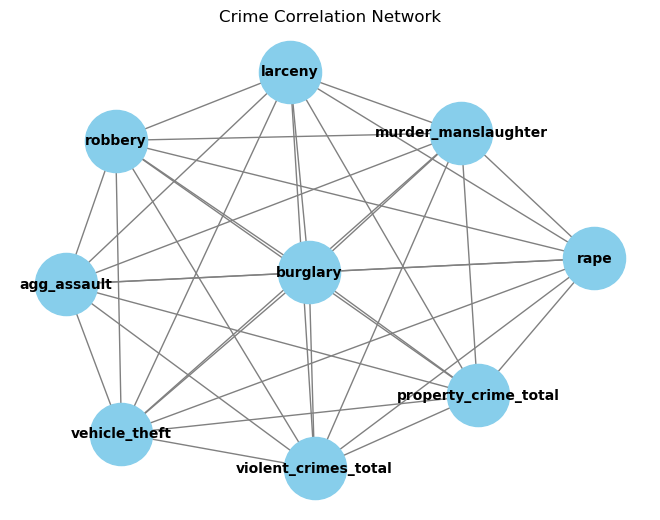

In [48]:
import networkx as nx


G = nx.Graph()
crime_types = ['violent_crimes_total', 'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total', 'burglary', 'larceny', 'vehicle_theft', 'rape']


G.add_nodes_from(crime_types)


corr_matrix = df_general[crime_types].corr()
for i in range(len(crime_types)):
    for j in range(i+1, len(crime_types)):
        if corr_matrix.iloc[i, j] > 0.5: 
            G.add_edge(crime_types[i], crime_types[j], weight=corr_matrix.iloc[i, j])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Crime Correlation Network')
plt.show()


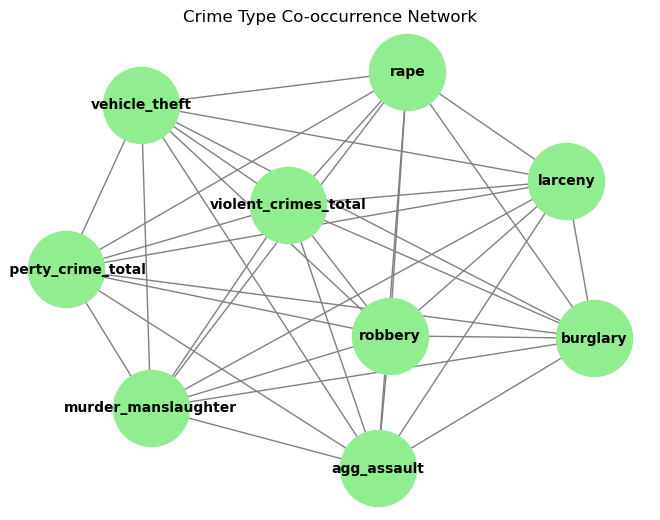

In [49]:
crime_types = ['violent_crimes_total', 'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total', 'burglary', 'larceny', 'vehicle_theft', 'rape']
co_occurrence_matrix = df_general.groupby('state_id')[crime_types].mean().corr()

G = nx.Graph()
for i in range(len(crime_types)):
    for j in range(i+1, len(crime_types)):
        if co_occurrence_matrix.iloc[i, j] > 0.5:  
            G.add_edge(crime_types[i], crime_types[j], weight=co_occurrence_matrix.iloc[i, j])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Crime Type Co-occurrence Network')
plt.show()


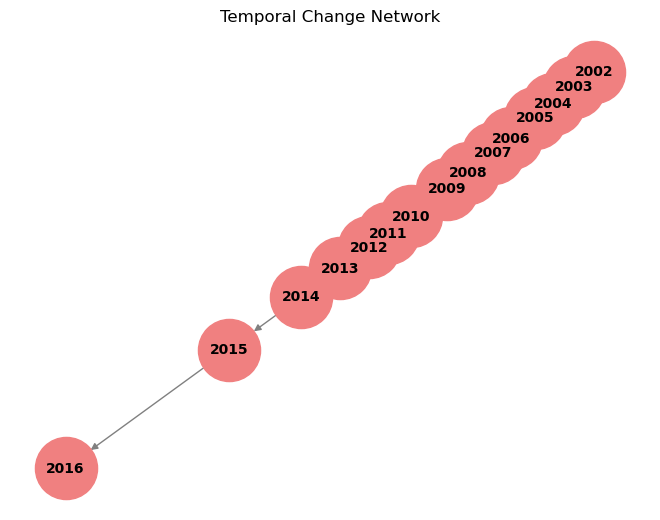

In [50]:
df_general['year'] = df_general['date'].dt.year
yearly_metrics = df_general.groupby('year')[['violent_crimes_total', 'unemployment_rate']].mean()

changes = yearly_metrics.diff().dropna()

G = nx.DiGraph()
for i in range(len(changes) - 1):
    year1 = changes.index[i]
    year2 = changes.index[i + 1]
    change_magnitude = np.sqrt(((changes.iloc[i] - changes.iloc[i + 1]) ** 2).sum())
    G.add_edge(year1, year2, weight=change_magnitude)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightcoral', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Temporal Change Network')
plt.show()


In [51]:
df_cases.columns

Index([' Case_id', 'juvenile_felony_count', 'juvenile_misdemeanor_count',
       'juvenile_other_offense_count', 'prior_offense_count',
       'days_between_screening_and_arrest',
       'days_from_compas_to_current_offense', 'is_recidivist', 'arrest_to_rec',
       'is_violent_recidivist', 'charge_id', 'rec_charge_id', 'inmate_id',
       'sentence_type_id', 'state_id', 'recidivism_offense_date_id',
       'current_jail_entry_date_id', 'current_jail_release_date_id',
       'screening_date_id', 'recidivism_risk_score_id',
       'violence_risk_score_id', 'date_id', 'year', 'month', 'day', 'date'],
      dtype='object')

<Axes: title={'center': 'Monthly Total of Juvenile Felony Counts'}, xlabel='date'>

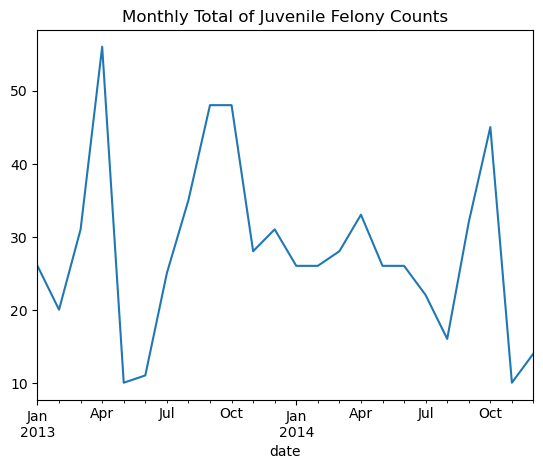

In [52]:
df_cases.set_index('date', inplace=True)
df_cases['juvenile_felony_count'].resample('M').sum().plot(title='Monthly Total of Juvenile Felony Counts')


<Axes: title={'center': 'Monthly Average of Juvenile Felony Counts'}, xlabel='date'>

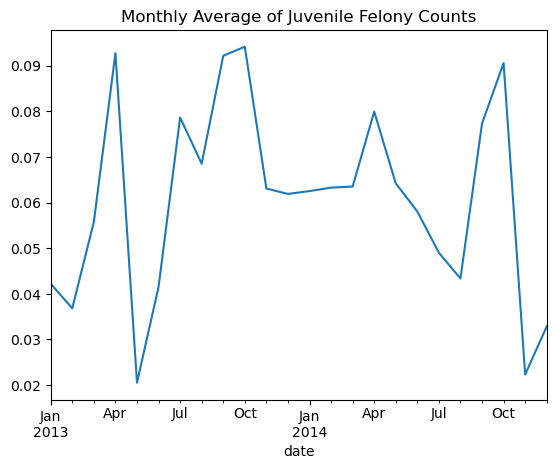

In [53]:
df_cases['juvenile_felony_count'].resample('M').mean().plot(title='Monthly Average of Juvenile Felony Counts')


In [54]:
df_cases.reset_index()

,date,Case_id,juvenile_felony_count,juvenile_misdemeanor_count,juvenile_other_offense_count,prior_offense_count,days_between_screening_and_arrest,days_from_compas_to_current_offense,is_recidivist,arrest_to_rec,...,recidivism_offense_date_id,current_jail_entry_date_id,current_jail_release_date_id,screening_date_id,recidivism_risk_score_id,violence_risk_score_id,date_id,year,month,day
0,2013-08-14,0,0,0,0,0,-1,1,0,0,...,-1,41498,41499,41499,1,1,41499,2013,8,14
1,2014-12-31,1,0,0,0,0,-1,-1,-1,0,...,-1,-1,-1,42003,2,9,42003,2014,12,31
2,2013-01-27,2,0,0,0,0,-1,1,1,0,...,41400,41299,41395,41300,3,1,41300,2013,1,27
3,2013-04-14,3,0,0,1,4,-1,1,1,0,...,41440,41376,41377,41377,4,3,41377,2013,4,14
4,2013-01-13,4,0,1,0,1,-1,1,0,0,...,-1,-1,-1,41286,5,6,41286,2013,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11008,2014-04-11,10996,0,0,0,0,-1,1,0,0,...,-1,-1,-1,41739,3,2,41739,2014,4,11
11009,2013-08-21,10997,0,0,0,5,-1,1,0,0,...,-1,41505,41506,41506,6,4,41506,2013,8,21
11010,2013-05-11,10998,0,0,0,0,-1,1,0,0,...,-1,41374,41404,41404,1,1,41404,2013,5,11
11011,2014-03-26,10999,0,0,0,3,-1,1,0,0,...,42157,41722,41723,41723,9,9,41723,2014,3,26


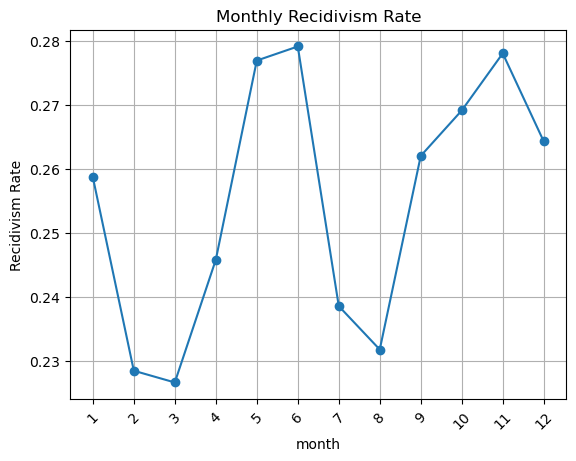

In [56]:
df_cases['year'] = df_cases['year'].astype(int)

# Plot yearly recidivism rate
yearly_recidivism_rate = df_cases.groupby('month')['is_recidivist'].mean()

# Create the plot
ax = yearly_recidivism_rate.plot(kind='line', marker='o', title='Monthly Recidivism Rate')
ax.set_xlabel('month')
ax.set_ylabel('Recidivism Rate')
plt.grid(True)
plt.xticks(yearly_recidivism_rate.index, rotation=45)  # Rotate x-axis for better visibility
plt.show()


In [95]:

merged_df = df_cases.merge(
    df_risk_scores[['id', 'risk_decile_score']], 
    left_on='recidivism_risk_score_id', 
    right_on='id', 
    how='left'
)

# Now merge the violence risk score
merged_df = merged_df.merge(
    df_risk_scores[['id', 'risk_decile_score']], 
    left_on='violence_risk_score_id', 
    right_on='id', 
    how='left'
)

# Drop redundant 'risk_score_id' columns if needed
merged_df.drop(columns=['id_x', 'id_y'], inplace=True)

# View the merged DataFrame
merged_df.head()
merged_df.rename(columns={'risk_decile_score_x': 'recidivism_risk_score', 'risk_decile_score_y': 'violence_risk_score'}, inplace=True)


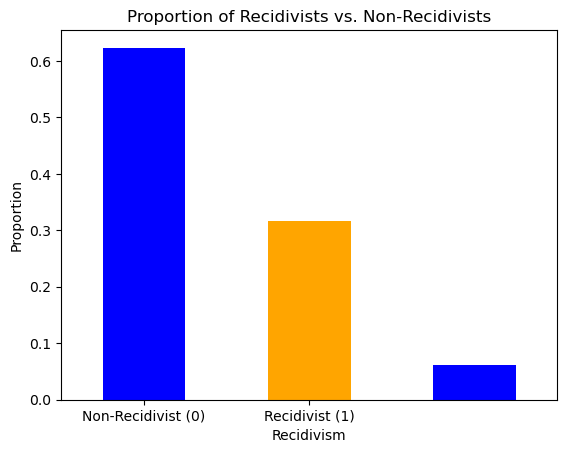

In [97]:
proportions = df_cases['is_recidivist'].value_counts(normalize=True)

# Plot
proportions.plot(kind='bar', color=['blue', 'orange'])
plt.title('Proportion of Recidivists vs. Non-Recidivists')
plt.xlabel('Recidivism')
plt.ylabel('Proportion')
plt.xticks(ticks=[0, 1], labels=['Non-Recidivist (0)', 'Recidivist (1)'], rotation=0)
plt.show()

<Axes: title={'center': 'Population and Poverty Numbers Over Time'}, xlabel='date'>

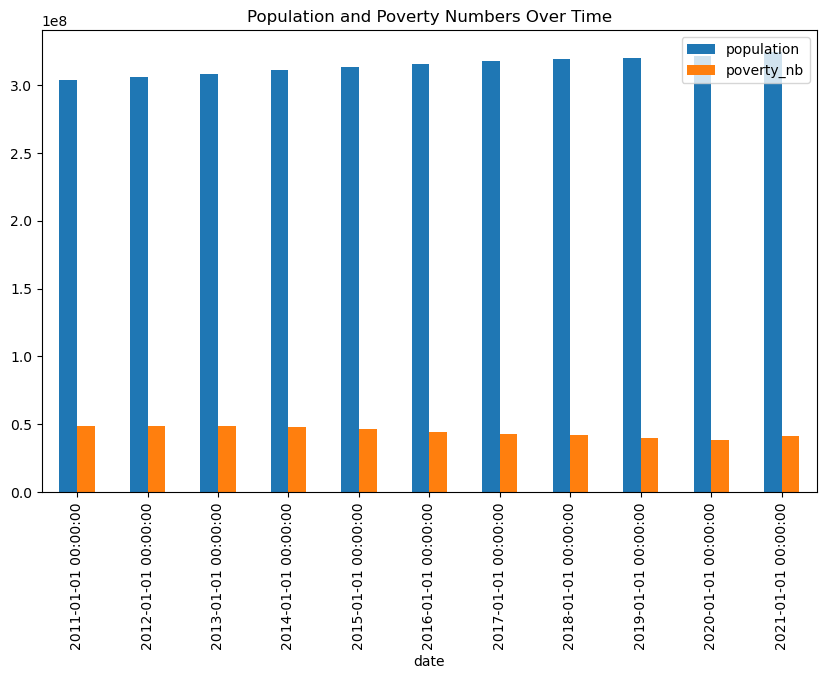

In [59]:
# Group by 'year' and sum the values for population and poverty_nb
df_grouped = df_filtered.groupby('date')[['population', 'poverty_nb']].sum()

# Plot the grouped data
df_grouped.plot(kind = 'line', title='Population and Poverty Numbers Over Time', figsize=(10, 6))


<Axes: title={'center': 'Count of Recidivism vs Non-Recidivism'}, xlabel='is_recidivist'>

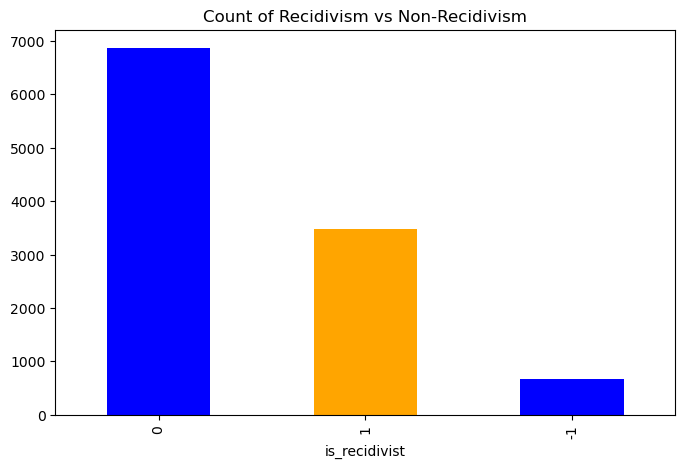

In [60]:
recidivism_counts = df_cases['is_recidivist'].value_counts()
recidivism_counts.plot(kind='bar', title='Count of Recidivism vs Non-Recidivism', figsize=(8, 5), color=['blue', 'orange'])


In [61]:
print(df_general.columns, df_cases.columns)

Index(['population', 'unemployment_rate', 'participation_rate', 'poverty_nb',
       'poverty_percentage', 'prisoners_count', 'violent_crimes_total',
       'murder_manslaughter', 'robbery', 'agg_assault', 'property_crime_total',
       'burglary', 'larceny', 'vehicle_theft', 'rape', 'state_id', 'date_id',
       'row_id', 'date', 'year'],
      dtype='object') Index([' Case_id', 'juvenile_felony_count', 'juvenile_misdemeanor_count',
       'juvenile_other_offense_count', 'prior_offense_count',
       'days_between_screening_and_arrest',
       'days_from_compas_to_current_offense', 'is_recidivist', 'arrest_to_rec',
       'is_violent_recidivist', 'charge_id', 'rec_charge_id', 'inmate_id',
       'sentence_type_id', 'state_id', 'recidivism_offense_date_id',
       'current_jail_entry_date_id', 'current_jail_release_date_id',
       'screening_date_id', 'recidivism_risk_score_id',
       'violence_risk_score_id', 'date_id', 'year', 'month', 'day', 'lag'],
      dtype='object')


In [103]:
df_cases.columns

Index([' Case_id', 'juvenile_felony_count', 'juvenile_misdemeanor_count',
       'juvenile_other_offense_count', 'prior_offense_count',
       'days_between_screening_and_arrest',
       'days_from_compas_to_current_offense', 'is_recidivist', 'arrest_to_rec',
       'is_violent_recidivist', 'charge_id', 'rec_charge_id', 'inmate_id',
       'sentence_type_id', 'state_id', 'recidivism_offense_date_id',
       'current_jail_entry_date_id', 'current_jail_release_date_id',
       'screening_date_id', 'recidivism_risk_score_id',
       'violence_risk_score_id', 'date_id', 'year', 'month', 'day', 'lag'],
      dtype='object')

In [115]:
df_inmates.columns

Index(['inmate_id', 'fullname', 'age', 'dob_id', 'gender_id', 'race_id',
       'age_group_id'],
      dtype='object')

In [121]:
merged_with_inmates = pd.merge(df_cases, df_inmates, how='inner', on='inmate_id')


In [125]:
final_merged_df = pd.merge(merged_with_inmates, df_ages, how='inner', on='age_group_id')


In [127]:
final_merged_df

,Case_id,juvenile_felony_count,juvenile_misdemeanor_count,juvenile_other_offense_count,prior_offense_count,days_between_screening_and_arrest,days_from_compas_to_current_offense,is_recidivist,arrest_to_rec,is_violent_recidivist,...,month,day,lag,fullname,age,dob_id,gender_id,race_id,age_group_id,age_group
0,0,0,0,0,0,-1,1,0,0,0,...,8,14,NaN,miguel hernandez,77,17274,1,1,5.0,65+
1,24,0,0,0,13,-1,1,1,0,0,...,2,5,1.0,columbus wilson,73,18806,1,3,5.0,65+
2,42,0,0,0,0,0,1,0,0,0,...,1,28,1.0,barrington figueroa,72,19232,1,3,5.0,65+
3,76,0,0,0,1,302,219,0,0,0,...,2,5,0.0,graciela quevedo,72,19220,2,4,5.0,65+
4,87,0,0,0,10,-1,906,1,0,0,...,3,12,1.0,erwin mallard,71,19457,1,3,5.0,65+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11007,10947,0,0,0,7,-1,62,0,0,0,...,7,25,1178.0,anthony lupo,60,23561,1,2,4.0,56-65
11008,10954,0,0,0,3,-50,1,0,0,0,...,9,12,1.0,patricia cooke,57,24502,2,2,4.0,56-65
11009,10956,0,0,0,7,-1,1,1,0,0,...,3,12,1.0,kevin brown,59,23789,1,3,4.0,56-65
11010,10957,0,0,0,2,0,1,0,0,0,...,5,26,1.0,edna lewis,57,24491,2,2,4.0,56-65


In [147]:
# Average age over time
average_age_per_year = final_merged_df.groupby('month')['age'].mean()

# Recidivism by age group over time
recidivism_by_age_group = final_merged_df.groupby(['month', 'age_group'])['is_recidivist'].mean()

# Visualize the distribution of age groups over time
age_group_distribution = final_merged_df.groupby(['year', 'age_group']).size().unstack()


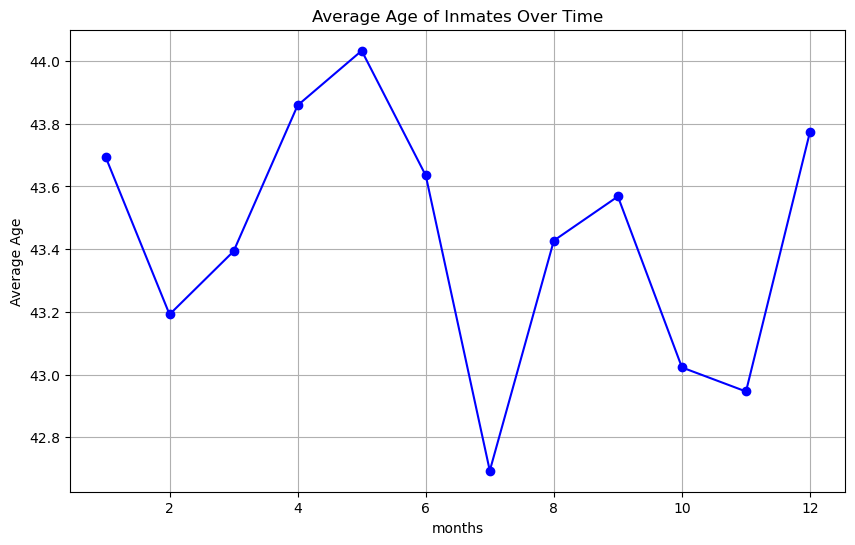

In [149]:
import matplotlib.pyplot as plt

# Plot average age over time
plt.figure(figsize=(10, 6))
plt.plot(average_age_per_year.index, average_age_per_year.values, marker='o', color='b', linestyle='-')
plt.title('Average Age of Inmates Over Time')
plt.xlabel('months')
plt.ylabel('Average Age')
plt.grid(True)
plt.show()


<Figure size 1200x800 with 0 Axes>

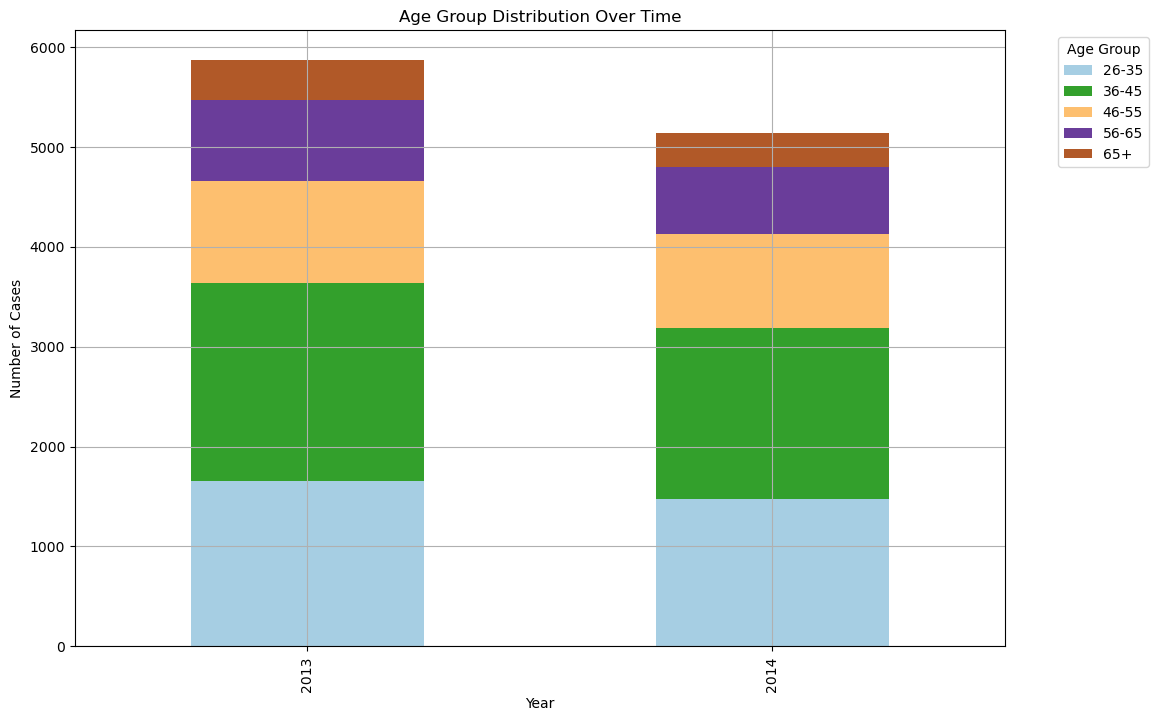

In [153]:
# Use Seaborn to plot a stacked bar plot of age group distribution
import seaborn as sns

plt.figure(figsize=(12, 8))
age_group_distribution.plot(kind='bar', stacked=True, colormap='Paired', figsize=(12, 8))
plt.title('Age Group Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
